## Analysis on FIA-MS data after SmartPeak processing
#### This script is based on the assumption that mass ranges and pos/neg have already been merged. Triplicates will be taken care of by only keeping metabolites that were detected in all three of them.

#### Blanks have not fully been taken care of as of yet, they're just processed like regular runs

In [3]:
import pymzml
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import statistics
import csv
import pickle
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer

import matplotlib.colors
from matplotlib_venn import venn3, venn3_circles, venn2, venn2_circles
from mpl_toolkits.mplot3d import Axes3D

from pandas.errors import EmptyDataError

import seaborn as sns
from collections import defaultdict

import xml.etree.ElementTree as ET

from pyopenms import *


Determination of memory status is not supported on this 
 platform, measuring for memoryleaks will never fail


## Process HMDB entries (not sure if necessary)
#### (thank you Svetlana)

In [2]:
"""
# from Svetlana

def parse_reference_metabolites(filepath):
    serum_metabolites = []
    root = ET.parse(filepath)
    obj = root.getroot()
    for metabolite in obj.findall('{http://www.hmdb.ca}metabolite'):
        status = metabolite.find('{http://www.hmdb.ca}status')
#         if status.text == 'quantified':
        weight = metabolite.find('{http://www.hmdb.ca}monisotopic_molecular_weight').text
        if weight:
            serum_metabolites.append({
                'accession': metabolite.find('{http://www.hmdb.ca}accession').text,
                'name': metabolite.find('{http://www.hmdb.ca}name').text,
                'monisotopic_molecular_weight': float(weight),
                'status': status.text,
            })
    return serum_metabolites
"""

In [ ]:
#serum_metabolites_all = parse_reference_metabolites('/Users/matmat/Documents/FIA-MS/serum_metabolites.xml')

In [ ]:
"""
serum_quantified = [s for s in serum_metabolites_all if s['status'] == 'quantified']
serum_all_ids = set(['HMDB:' + s['accession'] for s in serum_metabolites_all])
serum_quantified_ids = set(['HMDB:' + s['accession'] for s in serum_quantified])
"""

## Process HMDB entries from file

In [4]:
HMDB2StructMapping = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/CHEMISTRY/HMDB2StructMapping.tsv", 
                                 sep="\t", header=None)

In [5]:
SerumTop10 = pd.read_csv("/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts/traML.csv", 
                                 sep="\,", header=None)
SerumTop10 = list(SerumTop10.iloc[:,0])[1:]

/Users/matmat/opt/anaconda3/envs/FIA_MS/lib/python3.7/site-packages/ipykernel_launcher.py:2: ParserWarning:

Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.



## Load files

In [11]:
# Go to folder with relevant files

wd = "/Users/matmat/Documents/FIA-MS/20201007_FIA_MS_metk/20201007_FIA_MS_metk/features_HMDB_60sec/"

In [12]:
filenames_list = []
for (dirpath, dirnames, filenames) in os.walk(wd):
    filenames_list.extend(filenames)
    break

sorted_filenames_list = sorted(filenames_list)

In [13]:
len(sorted_filenames_list)

312

# Test (for analysis of all files go to "Actual loop")

In [18]:
features = FeatureMap()
FeatureXMLFile().load(wd + "/20200618_Blank_NewSourceSettings_20water_60MeOH_LH_POS_1.featureXML", features)

#### Check if everything is fine

In [20]:
for f in features:
      print ("Compound:", f.getMetaValue("PeptideRef").decode("utf-8"), " ", "Intensity: ", f.getMetaValue("peak_apex_int"))

Compound: HMDB:HMDB0000005   Intensity:  2309481.25
Compound: HMDB:HMDB0000019   Intensity:  1030647.8125
Compound: HMDB:HMDB0000020   Intensity:  552748.9375
Compound: HMDB:HMDB0000039   Intensity:  2355349.25
Compound: HMDB:HMDB0000162   Intensity:  262937.0625
Compound: HMDB:HMDB0000190   Intensity:  87313.29687500001
Compound: HMDB:HMDB0000202   Intensity:  275157.4375
Compound: HMDB:HMDB0000208   Intensity:  280189.0625
Compound: HMDB:HMDB0000209   Intensity:  610969.0625
Compound: HMDB:HMDB0000228   Intensity:  382435.25
Compound: HMDB:HMDB0000237   Intensity:  134612.5625
Compound: HMDB:HMDB0000243   Intensity:  726849.5
Compound: HMDB:HMDB0000246   Intensity:  392371.03125
Compound: HMDB:HMDB0000267   Intensity:  248315.046875
Compound: HMDB:HMDB0000329   Intensity:  141424.296875
Compound: HMDB:HMDB0000392   Intensity:  1856379.0
Compound: HMDB:HMDB0000393   Intensity:  177067.46875
Compound: HMDB:HMDB0000408   Intensity:  457963.96875
Compound: HMDB:HMDB0000422   Intensity:  

## Extract data into dataframe
#### IDs of Metabolites and intensities

In [21]:
extracted_data = {}
for f in features:
    if f.getMetaValue("PeptideRef").decode("utf-8") in HMDB2StructMapping[0].unique():
        extracted_data[f.getMetaValue("PeptideRef").decode("utf-8")] = (f.getMetaValue("peak_apex_int"))
extracted_data_df = pd.DataFrame(extracted_data.items(), columns=['Metabolite', 'Intensity'])

In [22]:
extracted_data_df

,Metabolite,Intensity
0,HMDB:HMDB0000005,2.309481e+06
1,HMDB:HMDB0000019,1.030648e+06
2,HMDB:HMDB0000020,5.527489e+05
3,HMDB:HMDB0000039,2.355349e+06
4,HMDB:HMDB0000162,2.629371e+05
...,...,...
161,HMDB:HMDB0060768,1.167984e+05
162,HMDB:HMDB0061870,2.506766e+05
163,HMDB:HMDB0061897,7.901716e+05
164,HMDB:HMDB0062210,3.654758e+05


# Process files

## Actual loop

In [ ]:
timestep_alldata = {}
for file in sorted_filenames_list:
    features = FeatureMap()
    FeatureXMLFile().load(wd + "/" + file, features)
    extracted_data = {}
    for f in features:
        if f.getMetaValue("PeptideRef").decode("utf-8") in HMDB2StructMapping[0].unique():
            extracted_data[f.getMetaValue("PeptideRef").decode("utf-8")] = (f.getMetaValue("peak_apex_int"))
    extracted_data_df = pd.DataFrame(extracted_data.items(), columns=['Metabolite', 'Intensity'])
    timestep_alldata[file] = extracted_data_df

## Calculate mean and variance for each metabolite

In [8]:
stats_of_files = {}
for file_n in range(0, len(timestep_alldata), 3):
    stats_of_compound = pd.DataFrame(columns = ['Metabolite', 'Mean', 'Variance', 'Rel_Stdv'])
    file = list(timestep_alldata.items())
    for metabolite_n in range(0, len(file[file_n][1])):
        if file[file_n][1]['Metabolite'][metabolite_n] in \
        list(file[file_n + 1][1]['Metabolite']) and \
        file[file_n][1]['Metabolite'][metabolite_n] in \
        list(file[file_n + 2][1]['Metabolite']):
            file_1 = file[file_n][1]
            file_2 = file[file_n + 1][1]
            file_3 =  file[file_n + 2][1]
            
            index_2 = list(file_2['Metabolite']).index(file_1['Metabolite'][metabolite_n])
            index_3 = list(file_3['Metabolite']).index(file_1['Metabolite'][metabolite_n])
            mean_of_compound = statistics.mean([file_1['Intensity'][metabolite_n],\
                                              file_2['Intensity'][index_2],\
                                              file_3['Intensity'][index_3]])
            variance_of_compound = statistics.variance([file_1['Intensity'][metabolite_n],\
                                                       file_2['Intensity'][index_2],\
                                                       file_3['Intensity'][index_3]])
            relstdev_of_compound = np.sqrt(variance_of_compound) / mean_of_compound
            stats = pd.DataFrame([[file_1['Metabolite'][metabolite_n], mean_of_compound, variance_of_compound, relstdev_of_compound]],\
                                columns = ['Metabolite', 'Mean', 'Variance', 'Rel_Stdv'])
            stats_of_compound = stats_of_compound.append(stats, ignore_index = True)
    stats_of_files[file[file_n][0][:-13]] = stats_of_compound

## Write to file

In [19]:
with open("features_30sec.txt", 'wb') as handle:
    pickle.dump(stats_of_files, handle)

In [106]:
with open("features_30sec.txt", 'rb') as handle:
    features_30sec = pickle.loads(handle.read())

# Functions

In [6]:
def extract_names_and_intensity(path_to_featureXML_dir, database_name_array):
    wd = path_to_featureXML_dir
    
    filenames_list = []
    for (dirpath, dirnames, filenames) in os.walk(wd):
        filenames_list.extend(filenames)
        break
    sorted_filenames_list = sorted(filenames_list)
    
    timestep_alldata = {}
    for file in sorted_filenames_list:
        features = FeatureMap()
        FeatureXMLFile().load(wd + "/" + file, features)
        extracted_data = {}
        for f in features:
            if f.getMetaValue("PeptideRef").decode("utf-8") in database_name_array:
                extracted_data[f.getMetaValue("PeptideRef").decode("utf-8")] = (f.getMetaValue("peak_apex_int"))
        extracted_data_df = pd.DataFrame(extracted_data.items(), columns=['Metabolite', 'Intensity'])
        timestep_alldata[file] = extracted_data_df
    
    return timestep_alldata

In [7]:
def calculate_mean_and_variance(extracted_info, txt_output_name):
    stats_of_files = {}
    for file_n in range(0, len(extracted_info), 3):
        stats_of_compound = pd.DataFrame(columns = ['Metabolite', 'Mean', 'Variance'])
        file = list(extracted_info.items())
        for metabolite_n in range(0, len(file[file_n][1])):
            if file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 1][1]['Metabolite']) and \
            file[file_n][1]['Metabolite'][metabolite_n] in \
            list(file[file_n + 2][1]['Metabolite']):
                file_1 = file[file_n][1]
                file_2 = file[file_n + 1][1]
                file_3 =  file[file_n + 2][1]

                index_2 = list(file_2['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                index_3 = list(file_3['Metabolite']).index(file_1['Metabolite'][metabolite_n])
                mean_of_compound = statistics.mean([file_1['Intensity'][metabolite_n],\
                                                  file_2['Intensity'][index_2],\
                                                  file_3['Intensity'][index_3]])
                variance_of_compound = statistics.variance([file_1['Intensity'][metabolite_n],\
                                                           file_2['Intensity'][index_2],\
                                                           file_3['Intensity'][index_3]])
                stats = pd.DataFrame([[file_1['Metabolite'][metabolite_n], mean_of_compound, variance_of_compound]],\
                                    columns = ['Metabolite', 'Mean', 'Variance'])
                stats_of_compound = stats_of_compound.append(stats, ignore_index = True)
        stats_of_files[file[file_n][0][:-13]] = stats_of_compound
        
    with open(txt_output_name, 'wb') as handle:
        pickle.dump(stats_of_files, handle)
    #return stats_of_files

In [14]:
wd = "/Users/matmat/Documents/FIA-MS/20200618_Source_Scanrange_Waste_Solvents_Adducts"

In [15]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_30sec", HMDB2StructMapping[0].unique()), wd + "/features_30sec.txt")

In [16]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_60sec", HMDB2StructMapping[0].unique()), wd + "/features_60sec.txt")

In [17]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_90sec", HMDB2StructMapping[0].unique()), wd + "/features_90sec.txt")

In [18]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_180sec", HMDB2StructMapping[0].unique()), wd + "/features_180sec.txt")

In [19]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_30sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_30sec.txt")

In [20]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_60sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_60sec.txt")

In [21]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_90sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_90sec.txt")

In [22]:
calculate_mean_and_variance(extract_names_and_intensity(wd + "/features_180sec", np.array(SerumTop10, dtype = object)), wd + "/SerumTop10_180sec.txt")

# Import generated data

In [23]:
with open(wd + "/features_30sec.txt", 'rb') as handle:
    features_30sec = pickle.loads(handle.read())
with open(wd + "/features_60sec.txt", 'rb') as handle:
    features_60sec = pickle.loads(handle.read())
with open(wd + "/features_90sec.txt", 'rb') as handle:
    features_90sec = pickle.loads(handle.read())
with open(wd + "/features_180sec.txt", 'rb') as handle:
    features_180sec = pickle.loads(handle.read())

In [24]:
with open(wd + "/SerumTop10_30sec.txt", 'rb') as handle:
    SerumTop10_30sec = pickle.loads(handle.read())
with open(wd + "/SerumTop10_60sec.txt", 'rb') as handle:
    SerumTop10_60sec = pickle.loads(handle.read())
with open(wd + "/SerumTop10_90sec.txt", 'rb') as handle:
    SerumTop10_90sec = pickle.loads(handle.read())
with open(wd + "/SerumTop10_180sec.txt", 'rb') as handle:
    SerumTop10_180sec = pickle.loads(handle.read())

#### Define parameters

In [28]:
sample_types = ['Blank', 'QCserum']
settings = ['NewSourceSettings', 'OldSourceSettings']
solvents = ['20water_60MeOH', '60_20AcN_water_AmCab_pH9', '60_20AcN_water_AmForm_pH3',
           '60_20isopropanol_water_AmCab_pH9', '60_20isopropanol_water_AmFor_pH3',
           '80_20AcN_water', '80_20MeOH_water']
methods = ['LH', 'M_0_2sWaste', 'M_0_4sWaste', 'M', 'M_HighInjSpeed_0_2sWaste',
          'M_HighInjSpeed_0_4sWaste', 'M_HighInjSpeed']
charges = ['POS', 'NEG']
masses = ['HighMass', 'LowMass']
times = [30, 60, 90, 180]
dates = ['20200618']

#### Set up df with columns for time steps, ref_list counts, methods and rows with solvents

In [30]:
results = {
    "time": [],
    "sample_type": [],
    "setting": [],
    "solvent": [],
    "method": [],
    "HMDB_counts": []
}

for t in [30]:
    for sample_type in sample_types:
        for setting in settings:
            if setting == 'NewSourceSettings':
                for solvent in solvents:
                    for method in methods:
                        results['time'].append(t)
                        results['sample_type'].append(sample_type)
                        results['setting'].append(setting)
                        results['solvent'].append(solvent)
                        results['method'].append(method)
                        a = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method
                        results['HMDB_counts'].append(len(features_30sec[a]))
            else:
                for solvent in solvents:
                    results['time'].append(t)
                    results['sample_type'].append(sample_type)
                    results['setting'].append(setting)
                    results['solvent'].append(solvent)
                    results['method'].append(methods[0])
                    b = dates + '_' + sample_type + '_' + setting + '_' + solvent + '_' + methods[0]
                    results['HMDB_counts'].append(len(features_30sec[b]))

pd.DataFrame(results)

KeyError: '20200618_Blank_NewSourceSettings_20water_60MeOH_LH'

In [317]:
"""
times = [30, 60, 90, 180]
for sample_type in sample_types:
    sns.set_context("poster")
    f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={'width_ratios': [10]*len(solvents) + [0.5]})
    cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
    for setting in settings:
        i = 0
        if setting == 'NewSourceSettings':
            print(sample_type)
            for solvent in solvents:
                df_heat = pd.DataFrame(index=methods, columns=times)
                for method in methods:
                    j = 0
                    for file in stats_files:
                        a = sample_type + '_' + setting + '_' + solvent + '_' + method
                        df_heat.loc[method, times[j]] = len(file[a])
                        j += 1
                sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=df_heat.max().max(), vmin=df_heat.min().min(),
                    square=True, linewidths=.5, cbar=(solvent=='20water_60MeOH'), cbar_ax=axs[-1], ax=axs[i])
                axs[i].set_ylim(len(methods), 0)
                axs[i].set_title(f'{solvent}')
                i += 1
            #plt.show()
    #f.savefig(sample_type + '.pdf')
            
#        else:
#            for solvent in solvents:
#                for files in stats_files:
#                    b = sample_type + '_' + setting + '_' + solvent + '_' + methods[0]
#                    len(files[b])
"""

'\ntimes = [30, 60, 90, 180]\nfor sample_type in sample_types:\n    sns.set_context("poster")\n    f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={\'width_ratios\': [10]*len(solvents) + [0.5]})\n    cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)\n    for setting in settings:\n        i = 0\n        if setting == \'NewSourceSettings\':\n            print(sample_type)\n            for solvent in solvents:\n                df_heat = pd.DataFrame(index=methods, columns=times)\n                for method in methods:\n                    j = 0\n                    for file in stats_files:\n                        a = sample_type + \'_\' + setting + \'_\' + solvent + \'_\' + method\n                        df_heat.loc[method, times[j]] = len(file[a])\n                        j += 1\n                sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=df_heat.max().max(), vmin=df_heat.min().min(),\n                    square=True, 

In [100]:
#stats_files = [features_30sec, features_60sec, features_90sec, features_180sec] 

In [103]:
stats_files = [SerumTop10_30sec, SerumTop10_60sec, SerumTop10_90sec, SerumTop10_180sec] 

In [104]:
#good_ones = []
collection = []
i = 0
for files in stats_files:
    new_dict = {}
    for keys in files.keys():
        #print('1900-01-01_0000' in keys)
        if '1900-01-01_0000' not in keys:
            #good_ones.append(keys)
            new_dict[keys] = stats_files[i][keys]
    collection.append(new_dict)
    i += 1

## Improved plots

Blank
POS


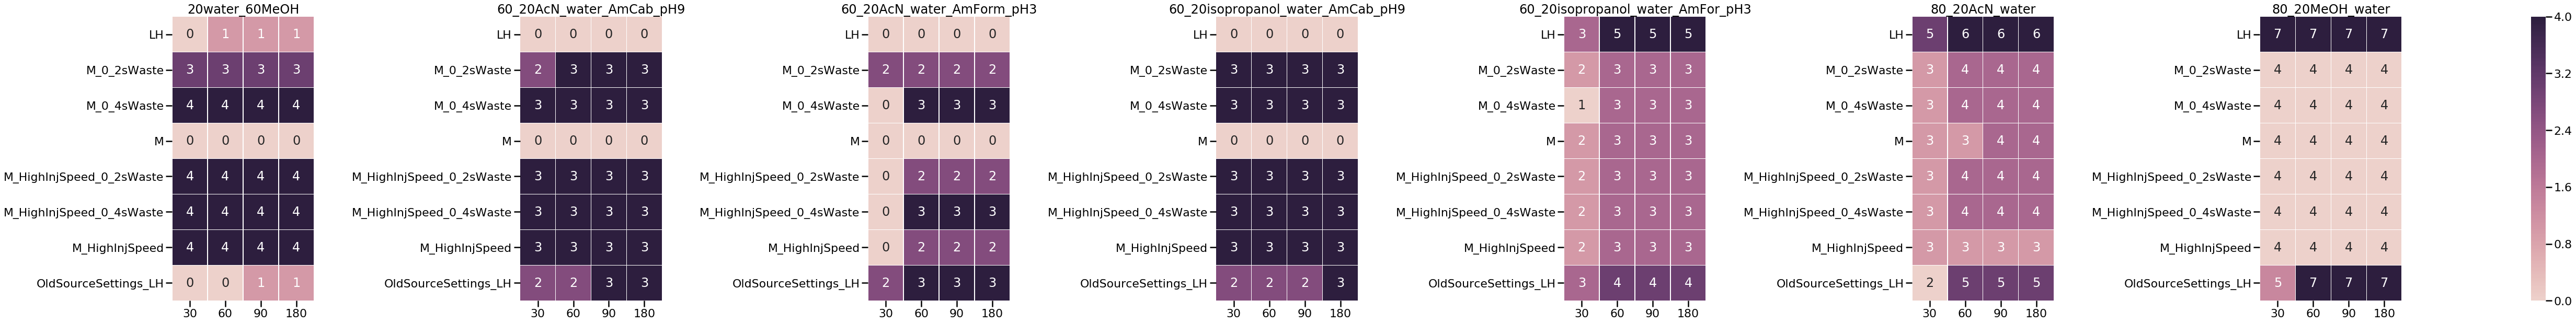

NEG


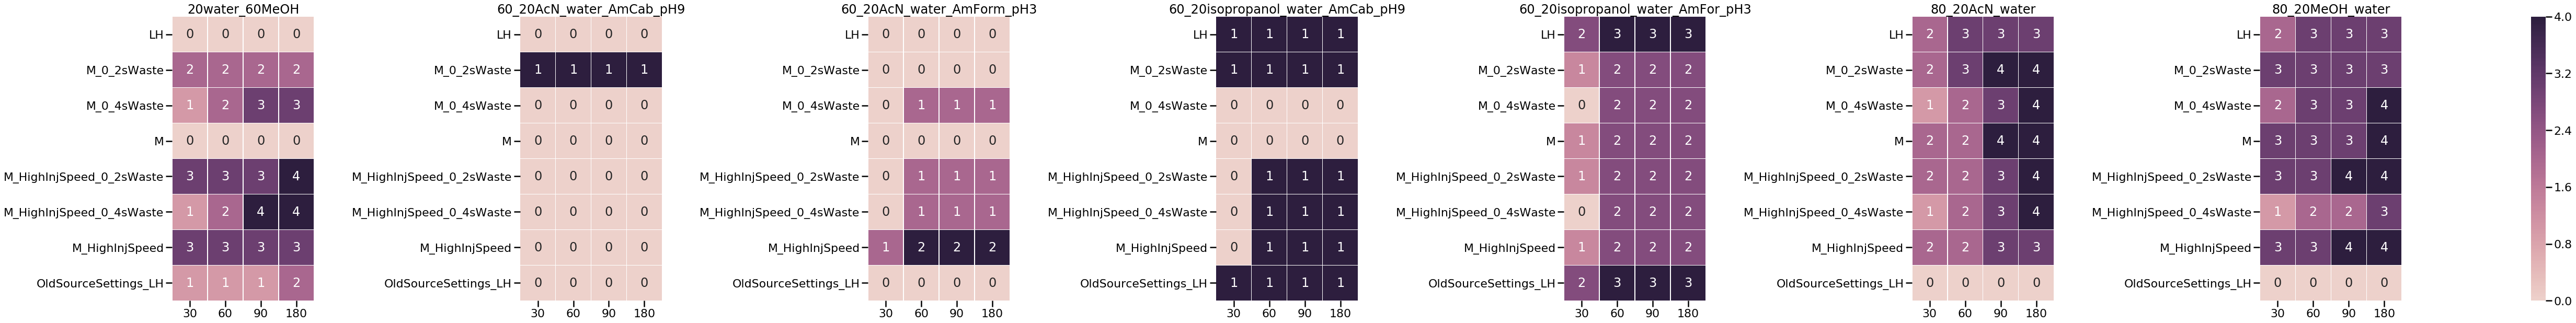

QCserum
POS


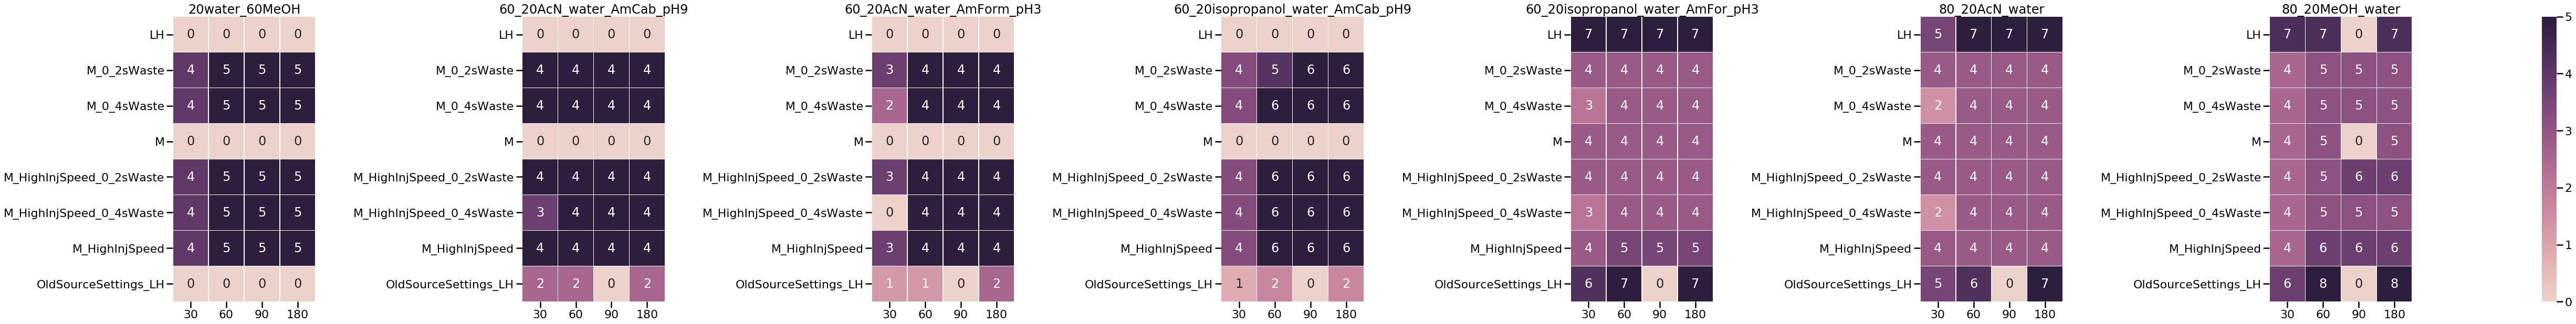

NEG


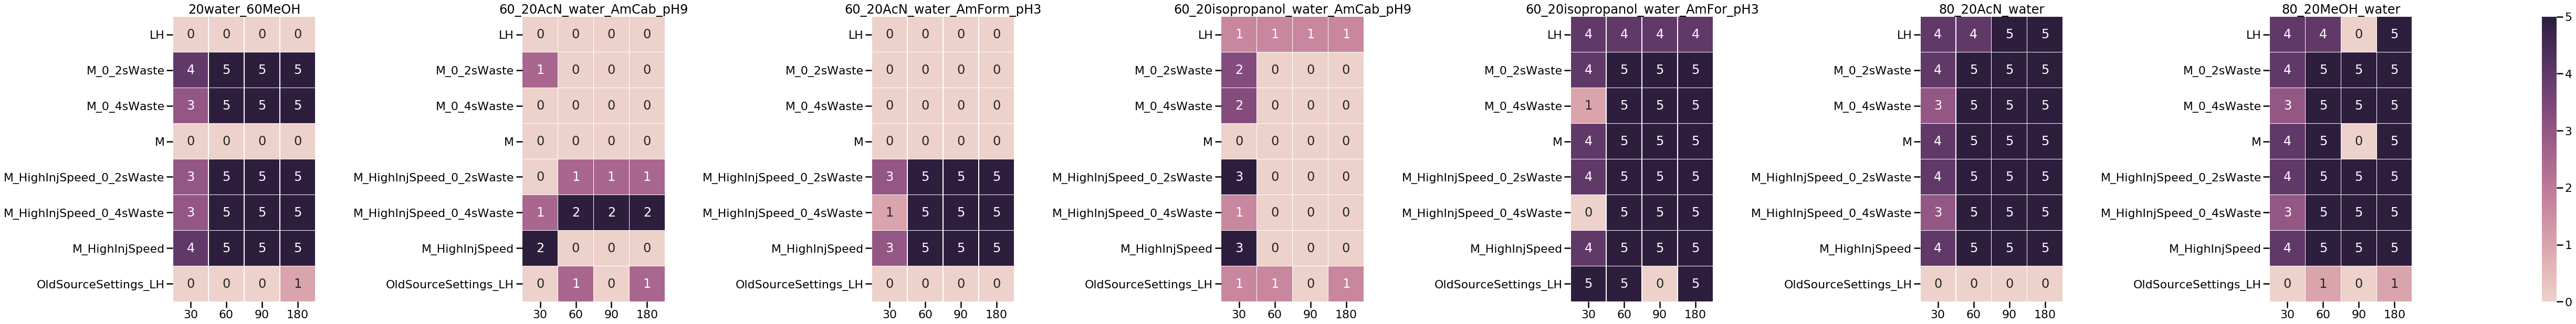

In [105]:
stats_files = collection
for sample_type in sample_types:
    print(sample_type)
    for charge in charges:
        print(charge)
        sns.set_context("poster")
        f, axs = plt.subplots(1, int((len(solvents) + 1)), figsize=(12*len(solvents), 10), gridspec_kw={'width_ratios': [10]*len(solvents) + [0.5]})
        cmap = sns.cubehelix_palette(as_cmap=True, n_colors=200)
        i = 0
        for solvent in solvents:
            df_heat = pd.DataFrame(index=methods + ['OldSourceSettings_LH'], columns=times)
            for method in methods:
                for setting in settings:
                    if setting == 'NewSourceSettings':
                        j = 0
                        for file in stats_files:
                            a = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + method + '_' + charge
                            df_heat.loc[method, times[j]] = len(file[a])
                            j += 1
                    else:
                        j = 0
                        for file in stats_files:
                            b = dates[0] + '_' + sample_type + '_' + setting + '_' + solvent + '_' + methods[0] + '_' + charge
                            df_heat.loc[(methods + ['OldSourceSettings_LH'])[len((methods + ['OldSourceSettings_LH'])) - 1], times[j]] = len(file[b])
                            j += 1
            sns.heatmap(df_heat, annot=True, fmt="d", cmap=cmap, vmax=df_heat.max().max(), vmin=df_heat.min().min(),
                square=True, linewidths=.5, cbar=(solvent=='20water_60MeOH'), cbar_ax=axs[-1], ax=axs[i])
            axs[i].set_ylim(len(methods + ['OldSourceSettings_LH']), 0)
            axs[i].set_title(f'{solvent}')
            i += 1
        plt.show()
        f.savefig('SerumTop10' + '_' + 
            sample_type + '_' + charge + '.pdf')

In [22]:
a = []
b = []

i = 0
for file in stats_files:
    for key in list(file.keys()):
        a.append(key + '_' + str(times[i]))
    i += 1

for file in stats_files:
    for key in list(file.keys()):
        for metabolite in file[key]['Metabolite']:
            if metabolite not in b:
                b.append(metabolite)

df_for_PCA = pd.DataFrame(index = b, columns = a)

In [30]:
j = 0
for file in stats_files:
    print('j = ' + str(j))
    k = 0
    for key in list(file.keys()):
        i = 0
        #print('k = ' + str(k))
        key
        for metabolite in file[key]['Metabolite']:
            df_for_PCA.at[metabolite, key + '_' + str(times[j])]  = file[key]['Mean'][i]
            i += 1
        k += 1
    j += 1

j = 0
j = 1
j = 2
j = 3


In [87]:
df = df_for_PCA.transpose()
df.index.name = 'Settings'
df.reset_index(inplace=True)
df

,Settings,HMDB:HMDB0000005,HMDB:HMDB0000019,HMDB:HMDB0000020,HMDB:HMDB0000039,HMDB:HMDB0000162,HMDB:HMDB0000202,HMDB:HMDB0000208,HMDB:HMDB0000209,HMDB:HMDB0000228,...,HMDB:HMDB0001543,HMDB:HMDB0002865,HMDB:HMDB0006459,HMDB:HMDB0014612,HMDB:HMDB0032937,HMDB:HMDB0040658,HMDB:HMDB0046021,HMDB:HMDB0059928,HMDB:HMDB0060375,HMDB:HMDB0060876
0,Blank_NewSourceSettings_20water_60MeOH_LH_30,1.99024e+06,916362,605432,2.02855e+06,207574,220340,215164,553944,324263,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Blank_NewSourceSettings_20water_60MeOH_M_0_2sW...,NaN,2.42984e+06,898183,NaN,2.3977e+06,642886,NaN,1.33064e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Blank_NewSourceSettings_20water_60MeOH_M_0_4sW...,2.56873e+06,3.42703e+06,1.28312e+06,NaN,3.51322e+06,554090,216133,2.17828e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Blank_NewSourceSettings_20water_60MeOH_M_30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Blank_NewSourceSettings_20water_60MeOH_M_HighI...,747208,2.03678e+06,713510,NaN,7.08482e+06,323040,NaN,1.45385e+06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,QCserum_OldSourceSettings_60_20AcN_water_AmFor...,3.97522e+07,7.64937e+06,8.90148e+06,NaN,5.04582e+06,5.62599e+06,2.7244e+06,1.02692e+07,1.78207e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
444,QCserum_OldSourceSettings_60_20isopropanol_wat...,2.88216e+07,4.66082e+06,3.57492e+06,9.74627e+06,3.99859e+06,3.31554e+06,1.13812e+06,1.05588e+07,1.98139e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
445,QCserum_OldSourceSettings_60_20isopropanol_wat...,7.55762e+07,4.67327e+07,5.22491e+06,5.03076e+07,5.8602e+08,2.45816e+07,3.39661e+06,1.01696e+07,3.59511e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
446,QCserum_OldSourceSettings_80_20AcN_water_LH_180,5.00003e+07,1.15464e+07,9.13747e+06,9.98818e+06,8.26865e+08,NaN,NaN,1.5835e+07,1.34699e+07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [56]:
df_for_PCA_impute = sklearn.impute.SimpleImputer(missing_values=np.NaN, strategy='constant', fill_value=0)
df_for_PCA_impute.fit(df)
df_new = df_for_PCA_impute.transform(df)

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

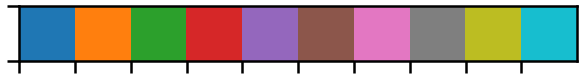

In [80]:
current_palette = sns.color_palette()
sns.palplot(current_palette)
current_palette

In [37]:
pca = PCA(n_components=2)

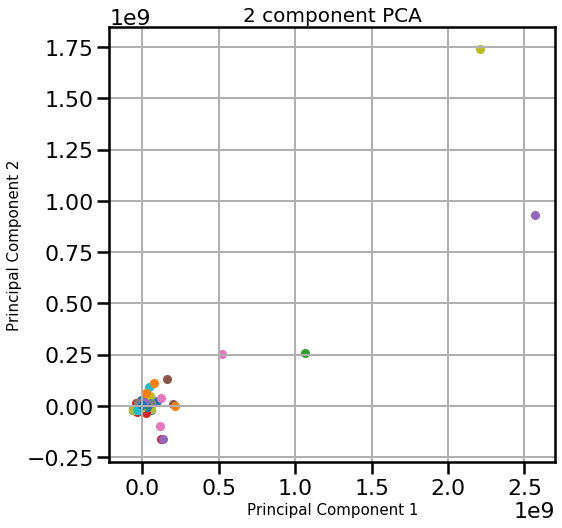

In [86]:
principalComponents = pca.fit_transform(df_new)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
finalDf = pd.concat([principalDf, df[['Settings']]], axis = 1)
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)


Settings = list(df['Settings'])
colors = sns.color_palette(None, len(Settings))
for setting, color in zip(Settings,colors):
    indicesToKeep = finalDf['Settings'] == setting
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = np.array([color])
               , s = 50)
#ax.legend(Settings)
ax.grid()

In [31]:
df_for_PCA

,Blank_NewSourceSettings_20water_60MeOH_LH_30,Blank_NewSourceSettings_20water_60MeOH_M_0_2sWaste_30,Blank_NewSourceSettings_20water_60MeOH_M_0_4sWaste_30,Blank_NewSourceSettings_20water_60MeOH_M_30,Blank_NewSourceSettings_20water_60MeOH_M_HighInjSpeed_0_2sWaste_30,Blank_NewSourceSettings_20water_60MeOH_M_HighInjSpeed_0_4sWaste_30,Blank_NewSourceSettings_20water_60MeOH_M_HighInjSpeed_30,Blank_NewSourceSettings_60_20AcN_water_AmCab_pH9_LH_30,Blank_NewSourceSettings_60_20AcN_water_AmCab_pH9_M_0_2sWaste_30,Blank_NewSourceSettings_60_20AcN_water_AmCab_pH9_M_0_4sWaste_30,...,QCserum_NewSourceSettings_80_20MeOH_water_M_HighInjSpeed_0_2sWaste_180,QCserum_NewSourceSettings_80_20MeOH_water_M_HighInjSpeed_0_4sWaste_180,QCserum_NewSourceSettings_80_20MeOH_water_M_HighInjSpeed_180,QCserum_OldSourceSettings_20water_60MeOH_LH_180,QCserum_OldSourceSettings_60_20AcN_water_AmCab_pH9_LH_180,QCserum_OldSourceSettings_60_20AcN_water_AmForm_pH3_LH_180,QCserum_OldSourceSettings_60_20isopropanol_water_AmCab_pH9_LH_180,QCserum_OldSourceSettings_60_20isopropanol_water_AmFor_pH3_LH_180,QCserum_OldSourceSettings_80_20AcN_water_LH_180,QCserum_OldSourceSettings_80_20MeOH_water_LH_180
HMDB:HMDB0000005,1.99024e+06,NaN,2.56873e+06,NaN,747208,1.29582e+06,173233,NaN,130218,NaN,...,2.86675e+06,3.10543e+06,3.18254e+06,NaN,1.98144e+07,3.97522e+07,2.88216e+07,7.55762e+07,5.00003e+07,8.35547e+07
HMDB:HMDB0000019,916362,2.42984e+06,3.42703e+06,NaN,2.03678e+06,2.72424e+06,1.77331e+06,NaN,324213,152905,...,1.01733e+07,9.90511e+06,1.06460e+07,NaN,3.80356e+06,7.64937e+06,4.66082e+06,4.67327e+07,1.15464e+07,6.23807e+07
HMDB:HMDB0000020,605432,898183,1.28312e+06,NaN,713510,1.14025e+06,509321,NaN,NaN,201673,...,2.19018e+06,2.26464e+06,2.35509e+06,6.382e+06,3.5459e+06,8.90148e+06,3.57492e+06,5.22491e+06,9.13747e+06,1.71335e+07
HMDB:HMDB0000039,2.02855e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.26014e+06,NaN,...,NaN,NaN,NaN,NaN,9.71211e+06,NaN,9.74627e+06,5.03076e+07,9.98818e+06,2.59165e+07
HMDB:HMDB0000162,207574,2.3977e+06,3.51322e+06,NaN,7.08482e+06,3.91513e+06,8.51144e+06,NaN,9.26104e+06,5.50997e+06,...,3.29273e+08,3.31365e+08,3.4027e+08,NaN,2.66033e+06,5.04582e+06,3.99859e+06,5.8602e+08,8.26865e+08,8.10609e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HMDB:HMDB0040658,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,154514
HMDB:HMDB0046021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,107384
HMDB:HMDB0059928,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,455612
HMDB:HMDB0060375,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140801
